- In this appendix, we add a few more advanced features to the training function, which are used in typical pretraining and finetuning; finetuning is covered in chapters 6 and 7
- The next three sections below discuss:
    - learning rate warmup
    - cosine decay
    - gradient clipping

In [1]:
from importlib.metadata import version
import torch
import tiktoken
from scripts.previous_chapters import GPTModel, create_dataloader_v1
import matplotlib.pyplot as plt

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

### Data

In [2]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [3]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

# Learning rate warmup

- When training complex models like LLMs, implementing learning rate warmup can help stabilize the training
- In learning rate warmup, we gradually increase the learning rate from a very low value (`initial_lr`) to a user-specified maximum (`peak_lr`)
- This way, the model will start the training with small weight updates, which helps decrease the risk of large destabilizing updates during the training

In [4]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01

- Typically, the number of warmup steps is between 0.1% to 20% of the total number of steps
- We can compute the increment as the difference between the `peak_lr` and `initial_lr` divided by the number of warmup steps

In [5]:
total_steps = len(train_loader) * n_epochs
print("Train steps:", len(train_loader))
print("Total steps:", total_steps)
warmup_steps = int(0.2 * total_steps) # 20% warmup
print("Warm up steps:", warmup_steps)

Train steps: 9
Total steps: 135
Warm up steps: 27


In [6]:
lr_increment = (peak_lr - initial_lr) / warmup_steps
print(lr_increment)

0.00036666666666666667


In [7]:
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
    
        if global_step < warmup_steps:
            # --------------- WARM UP ---------------
            lr = initial_lr + global_step * lr_increment
        else:
            # --------------- NON WARM UP (CONSTANT) -----------------
            lr = peak_lr
        
        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])
    
        # Calculate loss and update weights
        # ...

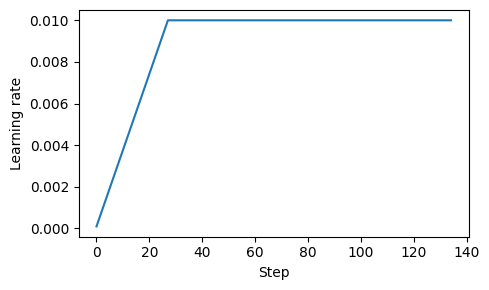

In [8]:
plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("1.pdf")
plt.show()

# Cosine Decay

- Another popular technique for training complex deep neural networks is cosine decay, which also **adjusts the learning rate across training epochs**
- In cosine decay, **the learning rate follows a cosine curve**, decreasing from its initial value to near zero following a half-cosine cycle
- **This gradual reduction is designed to slow the pace of learning** as the model begins to improve its weights; **it reduces the risk of overshooting minima as the training progresses**,  which is crucial for stabilizing the training in its later stages
- **Cosine decay is often preferred over linear decay for its smoother transition** in learning rate adjustments, but linear decay is also used in practice (for example, [OLMo: Accelerating the Science of Language Models](https://arxiv.org/abs/2402.00838))

In [9]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []

lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
    
        # Adjust the learning rate based on the current phase (warmup or cosine annealing)
        if global_step < warmup_steps:
            # --------------- WARM UP ---------------
            lr = initial_lr + global_step * lr_increment  
        else:
            # --------------- COSINE ANNEALING ---------------
            # Cosine annealing after warmup
            progress = ((global_step - warmup_steps) / 
                        (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                1 + math.cos(math.pi * progress))
        
        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])
    
        # Calculate loss and update weights

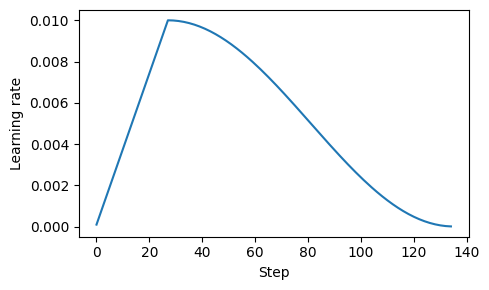

In [10]:
plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("2.pdf")
plt.show()

# Gradient Clipping

- Gradient clipping is yet another technique used to stabilize the training when training LLMs
- By setting a threshold, gradients exceeding this limit are scaled down to a maximum magnitude to **ensure that the updates to the model's parameters during backpropagation remain within a manageable range**
- For instance, using the `max_norm=1.0` setting in PyTorch's `clip_grad_norm_` method means that the norm of the gradients is clipped such that their maximum norm does not exceed 1.0
- the "norm" refers to a measure of the gradient vector's length (or magnitude) in the parameter space of the model
- Specifically, it's the L2 norm, also known as the Euclidean norm
- Mathematically, for a vector $\mathbf{v}$ with components $\mathbf{v} = [v_1, v_2, \ldots, v_n]$, the L2 norm is defined as:
$$
\| \mathbf{v} \|_2 = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2}
$$

- The L2 norm is calculated similarly for matrices.
- Let's assume our gradient matrix is:
$$
G = \begin{bmatrix}
1 & 2 \\
2 & 4
\end{bmatrix}
$$

- And we want to clip these gradients with a `max_norm` of 1.

- First, we calculate the L2 norm of these gradients:
$$
\|G\|_2 = \sqrt{1^2 + 2^2 + 2^2 + 4^2} = \sqrt{25} = 5
$$

- Since $\|G\|_2 = 5$ is greater than our `max_norm` of 1, we need to scale down the gradients so that their norm is exactly 1. The scaling factor is calculated as $\frac{max\_norm}{\|G\|_2} = \frac{1}{5}$.

- Therefore, the scaled gradient matrix $G'$ will be as follows:
$$
G' = \frac{1}{5} \times G = \begin{bmatrix}
\frac{1}{5} & \frac{2}{5} \\
\frac{2}{5} & \frac{4}{5}
\end{bmatrix}
$$

In [11]:
from scripts.previous_chapters import calc_loss_batch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

- If we call `.backward()`, PyTorch will calculate the gradients and store them in a `.grad` attribute for each weight (parameter) matrix
- Let's define a utility function to calculate the highest gradient based on all model weights

In [12]:
max_grad = None
for param in model.parameters():
    if param.grad is not None:
        grad_values = param.grad.data.flatten()
        max_grad_param = grad_values.max()
        if max_grad is None or max_grad_param > max_grad:
            max_grad = max_grad_param

In [13]:
mparams = model.parameters()

In [14]:
len(["1" for _ in mparams])

161

In [15]:
mparams = model.parameters()
mparam = next(mparams)

In [16]:
mparam.shape

torch.Size([50257, 768])

In [17]:
mparam.grad.shape

torch.Size([50257, 768])

In [18]:
mparam.grad.data.flatten().max()

tensor(0.0005, device='cuda:0')

In [19]:
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

print(find_highest_gradient(model))

tensor(0.0428, device='cuda:0')


- Applying gradient clipping, we can see that the largest gradient is now substantially smaller:

In [20]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_highest_gradient(model))

tensor(0.0192, device='cuda:0')


# All together to improve training

In [21]:
from scripts.previous_chapters import evaluate_model, generate_and_print_sample

BOOK_VERSION = True


def train_model(model, train_loader, val_loader, optimizer, device,
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):

    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    # Retrieve the maximum learning rate from the optimizer
    peak_lr = optimizer.param_groups[0]["lr"]

    # Calculate the total number of iterations in the training process
    total_training_steps = len(train_loader) * n_epochs

    # Calculate the learning rate increment during the warmup phase
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            # Adjust the learning rate based on the current phase (warmup or cosine annealing)
            if global_step < warmup_steps:
                # Linear warmup
                lr = initial_lr + global_step * lr_increment  
            else:
                # Cosine annealing after warmup
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            # Apply the calculated learning rate to the optimizer
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # Store the current learning rate

            # Calculate and backpropagate the loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            # Apply gradient clipping after the warmup phase to avoid exploding gradients

            if BOOK_VERSION:
                if global_step > warmup_steps:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
            else:
                if global_step >= warmup_steps:  # the book originally used global_step > warmup_steps, which lead to a skipped clipping step after warmup
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
            optimizer.step()
            tokens_seen += input_batch.numel()

            # Periodically evaluate the model on the training and validation sets
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # Print the current losses
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        # Generate and print a sample from the model to monitor progress
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen, track_lrs

In [22]:
import tiktoken

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001  # this was originally set to 5e-4 in the book by mistake
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)  # the book accidentally omitted the lr assignment
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 15
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer, warmup_steps=warmup_steps, 
    initial_lr=1e-5, min_lr=1e-5
)

Ep 1 (Iter 000000): Train loss 10.969, Val loss 10.938
Ep 1 (Iter 000005): Train loss 9.336, Val loss 9.461
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.817, Val loss 8.187
Ep 2 (Iter 000015): Train loss 6.338, Val loss 6.893
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 6.075, Val loss 6.595
Ep 3 (Iter 000025): Train loss 5.676, Val loss 6.767
Every effort moves you, the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the
Ep 4 (Iter 000030): Train loss 5.678, Val loss 6.868
Ep 4 (Iter 000035): Train loss 5.691, Val loss 6.802
Every effort moves you.                                                 
Ep 5 (Iter 000040): Train loss 5.110, Val loss 6.522
Every effort moves you, and a a a a a, and a a of the his of the his, I had, and I had been had a, and I h

### Check the learning rate

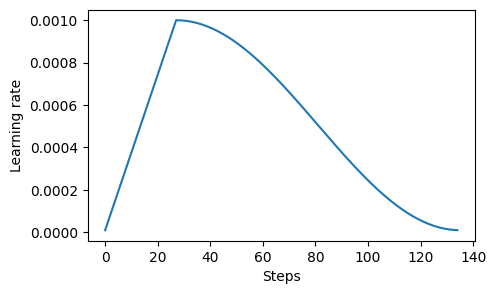

In [23]:
plt.figure(figsize=(5, 3))
plt.plot(range(len(lrs)), lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

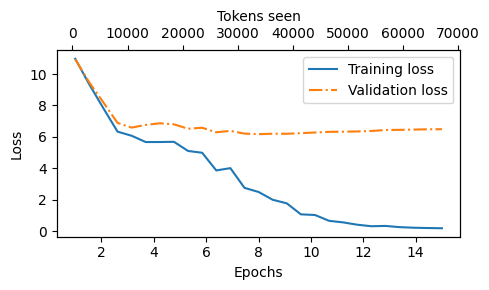

<Figure size 640x480 with 0 Axes>

In [24]:
from scripts.previous_chapters import plot_losses

epochs_tensor = torch.linspace(1, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.tight_layout(); plt.savefig("3.pdf")
plt.show()

In [25]:
print(f"Maximum GPU memory allocated: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")

Maximum GPU memory allocated: 4.61 GB


## Decoding Strategies

In [26]:
from scripts.previous_chapters import generate_text_simple, text_to_token_ids, token_ids_to_text

In [27]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### Temperature Scaling

- Previously, we always sampled the token with the highest probability as the next token using `torch.argmax`
- To add variety, we can sample the next token using The `torch.multinomial(probs, num_samples=1)`, sampling from a probability distribution
- Here, **each index's chance of being picked corresponds to its probability in the input tensor**

In [28]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [29]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [30]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


- We can control the distribution and selection process via a concept called **temperature scaling**
- **"Temperature scaling" is just a fancy word for dividing the logits by a number greater than 0**
- Temperatures greater than 1 will result in more uniformly distributed token probabilities after applying the softmax
- Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions after applying the softmax

In [31]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

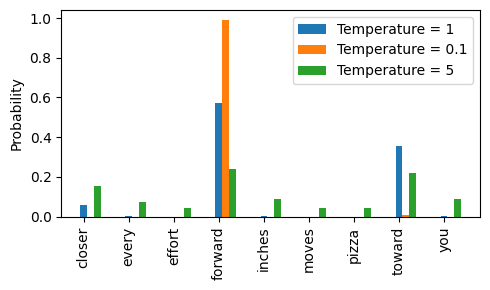

In [32]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

### top-k sampling

**We can restrict the sampled tokens to the top-k most likely tokens:**

In [33]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [34]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [35]:
new_logits = torch.full_like( # create tensor containing -inf values
    next_token_logits, -torch.inf
)   

In [36]:
new_logits

tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])

In [37]:
top_pos

tensor([3, 7, 0])

In [38]:
new_logits[top_pos] = next_token_logits[top_pos] # copy top k values into 

In [39]:
new_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [40]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [41]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [42]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen a little wild--I looked of struck by his last


# Saving

- It's common to train LLMs with adaptive optimizers like Adam or AdamW instead of regular SGD
- These adaptive optimizers store additional parameters for each model weight, so it makes sense to save them as well in case we plan to continue the pretraining later:

In [43]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

### Loading

In [44]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

/tmp/ipykernel_327101/2328250181.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth", map_location=device)


In [45]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you get up him. By Jack!i? Why: "Whenating laugh
